<a href="https://colab.research.google.com/github/MelihKlc/Deep-Learning/blob/main/Milestone_Project_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

# Get data

Since we will be replicating the paper above (PubMed 200k RCT) , lets download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct  # Githubdan data cekerken git clone kullanıyoruz

!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 23.75 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# 20K dataset koymalarının sebebi önce kücük datasette calısıp sonrasında upscale etmek. (%10 of original dataset)
# Check the files are in the PubMed_20k_ dataset
# Dev.txt aslında validation set için konulan başka bir isim
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/   # Burda sayılar yerine @ konulmus sekilde geliyo datasetimiz. Aslında preprocess edilmis oluyo bir kısmı.

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [3]:
# Start our experiments using the 20K dataset with number replaced by "@" sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Check all of the filenames in the target directory.
import os

filenames = [ data_dir + filename for filename in os.listdir(data_dir) ]
filenames

#for döngüsünden sonra gelen filename, her bir döngü iterasyonunda listenin içindeki dosya ve dizin adlarını temsil eden bir değişkendir. Yani her döngü adımında filename değişkeni, listenin içindeki sıradaki dosya veya dizin adını alır.

#Örneğin, eğer os.listdir(data_dir) çağrısıyla data_dir dizininde bulunan dosya ve dizin adları şunlar ise: ['dosya1.txt', 'dosya2.txt', 'alt_dizin']

#for filename in os.listdir(data_dir) ifadesi döngüye başladığında filename şu değerleri alacaktır:

#İterasyon 1: filename = 'dosya1.txt'
#İterasyon 2: filename = 'dosya2.txt'
#İterasyon 3: filename = 'alt_dizin'

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Preprocess data

Now we have got some text data , it is time to become one with it.

And one of the best ways to become one with the data is to..

> Visualize

So with that in mind , lets write a function to read in all of the lines of a target text file

In [5]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  # r means read and f means file. Open this file(filename) and save it as f
  with open(filename , "r") as f:
    return f.readlines()  # This reads the remaining lines from the file object and returns them as a list.


In [6]:
# Lets read in the training lines

train_lines = get_lines(data_dir + "train.txt" )
train_lines[ : 27 ]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Lets think about how we want out data to look..

How i think our data would be best represented..

We will represent our data with dictionary

Emotional eatingle baslayan yeri kullanıyoruz.

'  [ {  ' line_number ' : 0  ,
' target ' : ' BACKGROUND ' ,
' text ' : "BACKGROUND\tEmotional eating is associated with overeating and the development of obesity .\n" ,
' total_lines ' : 11  (sentence in our special abstract) }]  '

Bizim datamızda order önemli çünkü conclusion cümlesinin başta olması saçma olur bu yüzden ordera dikkat edeceğiz.

Bunu bitirdiğimizde liste içinde 11 dictionarymiz olması gerek.

Niye bunu kullanıyoruz? Çünkü pythonda kendi data structure ımızı oluşturmak çok önemli şu an datamızda bir structure yok bu yüzden biz bunu list of dictionaries structure ına çevireceğiz.



# Lets write a function which turns each of our datasets into the above format so we can continue to prepare

In [7]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstarct line data.

  Takes in filename , reads in contents and sorts through each line ,
  extracting things like the target label , the text of the sentence ,
  how many sentences are in the current abstract and what sentence number
  the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract. abstractlar \n ile ayrıldıgı icin biz de burda abstractları ayırıyoruz.
  abstract_samples = [] # Create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):  # Check to see if the line is an ID line. Bu methodla ### ile başlayan line gelirse yi test ediyoruz.
      abstract_id = line
      abstract_lines = ""   # Reset the abstract string if the line is an ID line. Yani id line geldiginde abstractımızı resetleyip basta yaptıgımız isleme dönüyoruz.
    elif line.isspace():  # Check to see if line is a new line. Artık buraya geldiğimizde abstractları ayırdık. Simdi de abstract içindeki cümleleri ayırmamız gerekiyor. Bu yüzden isspace kullanıyoruz bu da new line gördüğünde devreye giriyor yani \n gördüğünde.
      abstract_line_split = abstract_lines.splitlines()  # Split abstract into seperate lines. splitlines fonksiyonu ile \n yani new line gördüğünde artık onu line olarak ayarlıyor ve aşağıya geçtiğinde farklı bir line a geçmiş oluyoruz.

         # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
          line_data = {}  # Create an empty dictionary for each line. Her line için yukarıda bir pattern yazmıştık onu oluşturuyoruz.
          target_text_split = abstract_line.split("\t") # Split target label from text
          line_data["target"] = target_text_split[0] # Get target labels. target_text_split ile textimizi labelından ayırdık. Şimdi line_data adında bir data olusturduk yukarıda dictionary olarak ve buna target adında bir feature ekledik bu labelları tutacak içinde. target_text_split[0] 0. index dediğimiz zaten labellar oluyo biz 2 indexe ayırdık target ve text olarak.
          line_data["text"] = target_text_split[1].lower()  # Textteki tüm harfleri kücük harfe ceviriyoruz lower methodu ile.
          line_data["line_number"] = abstract_line_number # What number line does the line appear in the abstract.
          line_data["total_lines"] = len(abstract_line_split) - 1  # -1 , indexler 0 dan basladıgı icin. How many total lines are there in the target abstract?
          abstract_samples.append(line_data)  # add line data to abstract sample list. Burda artık line_data ile gerekli dictionary mizi olusturduk simdi list of dictionary kullanacagımız icin en basta olusturdugumuz empty listeye dictionarymizi ekliyoruz.
    else:
      abstract_lines += line  # If the above conditions arent satisfied , the line contains a labelled sentence . If it is not an id line (doesnt begin with ###) and if it also is not an empty string, the else statement is saying all of these lines between the ### and between the new line (\n) are part of the same abstract
  return abstract_samples

In [8]:
# Get data from file and preprocess it. (%%time ne kadar surdugunu ogrenmek icin)
%%time
train_samples = preprocess_text_with_line_numbers(data_dir +"train.txt")
train_samples[ : 20]


CPU times: user 626 ms, sys: 88.6 ms, total: 715 ms
Wall time: 838 ms


[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [9]:
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
test_samples[ : 30]

[{'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'line_number': 0,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'line_number': 1,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'line_number': 2,
  'total_lines': 8},
 {'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ %

# Now that our data is the format of a list of dictionaries , how about we turn into a DataFrame to further vision

In [10]:
import pandas as pd   # Bizim datalarımızı dictionary formata getirme sebeplerimizin birisi de dictlerin pandas ile DataFrame şekline kolay çevrilebilmesi.
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [11]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

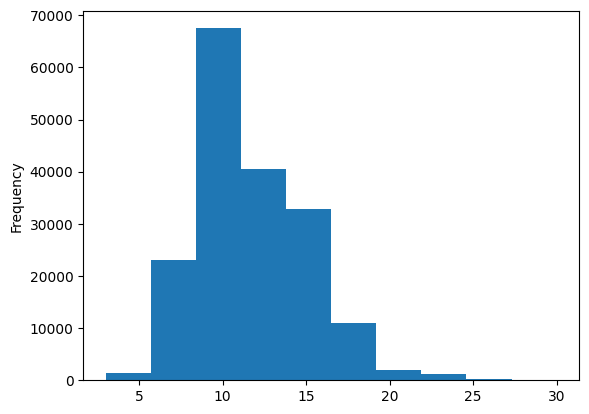

In [12]:
# Lets check the length of different lines
train_df.total_lines.plot.hist();

# Get list of sentences

In [13]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [14]:
# View the 10 lines of training sentences
train_sentences[ : 10]


['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make numeric labels (ML models require numeric labels)

# First we will encode with one hot encoder and then we will use label encoder

In [15]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse = False)  # We want non-sparse matrix

train_labels_encoded = encoder.fit_transform(train_df["target"].to_numpy().reshape( -1 , 1 )) # Reshape yapmamız gerekiyor cünkü 2d array bekleniyor input olarak
train_labels_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
val_labels_encoded = encoder.transform(val_df["target"].to_numpy().reshape( -1  , 1))
test_labels_encoded = encoder.transform(test_df["target"].to_numpy().reshape( -1  , 1))
# We wont use fit again because we already fitted in train_labels_encoded our encoder object , so fitting val and test labels are unnecessary

# Label encode labels

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
encoder_2 = LabelEncoder()

train_labels_encoded_labelencoder = encoder_2.fit_transform(train_df["target"].to_numpy())
val_labels_encoded_labelencoder = encoder_2.transform(val_df["target"].to_numpy())
test_labels_encoded_labelencoder = encoder_2.transform(test_df["target"].to_numpy())

In [18]:
test_labels_encoded_labelencoder[ : 10]

array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(encoder_2.classes_)
class_names = encoder_2.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Starting a series of modelling experiments

As usual , we are going to be trying out a bunch of different models and seeing which one works best.

And as always , we are going to start with a baseline (TF-IDF multinomial naive bayes)

# Model 0 : Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline

model_0 = Pipeline( [

                   ("tfidf" , TfidfVectorizer()) ,
                   ("clf" , MultinomialNB())
]
)

# Fit the pipeline to the training data
model_0.fit(
    X =  train_sentences ,
 y =   train_labels_encoded_labelencoder

)
# TfidfVectorizer terim frekansı ters belge frekansı (TF-IDF) değerlerini hesaplamak için kullanılır. Bu yöntem, bir belge içerisindeki bir terimin önemini, hem belge içerisindeki sıklığına hem de tüm belgelerdeki görülme sıklığına dayalı olarak belirler. Bu sayede metinlerin içerdikleri kelimelerin anlamlılığını belirlemek için kullanılır.
# MultinomialNB, çok sınıflı Bayes sınıflandırıcılarından biridir ve metin sınıflandırma gibi problemlerde kullanılır. Naive Bayes algoritması, Bayes teoremi temel alınarak çalışır ve bir metni belirli sınıflara tahmin etmek için metindeki özelliklerin olasılıklarını kullanır. Bu durumda, sınıflandırıcı, veri setindeki sınıfları tahmin etmek için metin özelliklerini (TF-IDF değerleri) kullanacaktır.

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation set
model_0.score(
    X = val_sentences ,
    y = val_labels_encoded_labelencoder
)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

# We will compare predictions across different metrics (accuracy , precision , recall , f1-score)



In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [24]:
baseline_results = calculate_results(
    y_true = val_labels_encoded_labelencoder ,
    y_pred = baseline_preds

)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 1: Conv1D with token embeddings

# Create a text vectorizer layer

We want to make a layer which maps our texts from words to number

In [25]:
# How long is each sentence on average?
import numpy as np
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

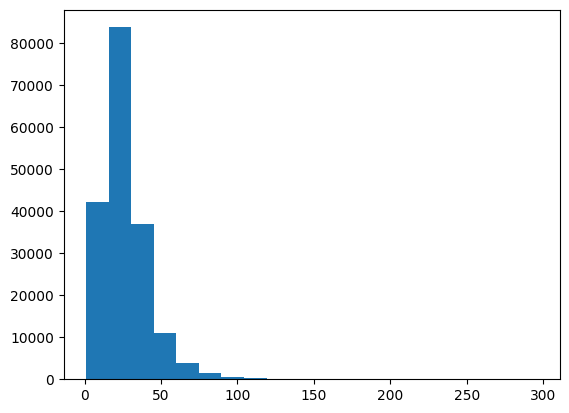

In [26]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [27]:
# Find the average number of tokens in the training texts
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

26

In [28]:
# How long of a sentence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len  # output length kaç seçersek bizim datamızın %95 ini kapsar?

55

In [29]:
# How many word are in our vocab? (taken from table 2 in our dataset paper , we have 68000 words)
max_tokens = 68000

In [30]:
# We will create our textvectorizer function for convertinf text into numbers

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#ngram substringleri birleştiriyor. Mesela elimizde 'Imagine getting flattened by Kurt Zouma' cümlesi var. ngram = 2 dersek , "Image getting" , "flattened by" , "Kurt Zouma"  gibi ikişer ikişer substringleri birleştiriyor.

# Default values of TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens , # How many words in the vocabulary ( automatically add <00V>)
                                                       output_sequence_length = 55 , # Desired lenght of vectorized output length of vectorized sequences
                                    )

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\n Length of text : {len(target_sentence.split())}\n")
print(f"Text vectorized form of the text : \n{text_vectorizer([target_sentence])}")

Text:
logistic regression models were fit , adjusting for age , sex , race , bmi , cvd risk factors , cvd , and study site .

 Length of text : 26

Text vectorized form of the text : 
[[ 959  388  476    9 2188 1515   11  103  693 2468  456 1594   73  254
  1594    3   17  674    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [33]:
# How many words in our training vocab?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in our vocab : {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab : { rct_20k_text_vocab[ :  5 ] }")
print(f"Least common words in the vocab : { rct_20k_text_vocab[ -5 : ] }")


Number of words in our vocab : 64841
Most common words in the vocab : ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

# Create an embedding layer

In [35]:
from tensorflow.keras import layers

embedding = layers.Embedding( input_dim = len(rct_20k_text_vocab) ,  # set input shape
                              output_dim = 128 , # Output shape. Every token in the format of 128 long vector
                              mask_zero = True  # Input length 55 dedigimiz icin uzun cümlelerin sonunda 0 lar kalacak . Tensorflow to do more efficient computing when there is lots of zeros.
                              )

In [36]:
# Show example embedding
# Cümleyi embed etmeden önce kesinlikle numerical form lazım bize o yüzden text vectorizationdan geçirmeden embedding yapamıyoruz.
print(f"Sentence before vectorization: \n {target_sentence}")
vectorized_sentence = text_vectorizer ([target_sentence])
print(f"\nVectorized form of our sentence (before embedding) : \n {vectorized_sentence}")
embedded_sentence = embedding(vectorized_sentence)
print(f"\nEmbedded form of our sentence : \n {embedded_sentence}")
print(f"\nShape of embedded form of sentence \n : {embedded_sentence.shape} ")

Sentence before vectorization: 
 logistic regression models were fit , adjusting for age , sex , race , bmi , cvd risk factors , cvd , and study site .

Vectorized form of our sentence (before embedding) : 
 [[ 959  388  476    9 2188 1515   11  103  693 2468  456 1594   73  254
  1594    3   17  674    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded form of our sentence : 
 [[[ 0.02091867  0.04585114  0.01550609 ...  0.02134326 -0.01716651
    0.04275917]
  [-0.0130051   0.02468995  0.04498234 ...  0.03635384 -0.00951552
   -0.01899233]
  [-0.03191489 -0.02974089 -0.0320208  ... -0.04402392  0.02255884
   -0.04622916]
  ...
  [ 0.0018751  -0.01384751  0.04547224 ...  0.01862096  0.00766098
   -0.04916186]
  [ 0.0018751  -0.01384751  0.04547224 ...  0.01862096  0.00766098
   -0.04916186]
  [ 0.0018751  -0.01384751  0.04547224 ...  0.01862

# Creating datasets (making sure our data loads as fast as possible)

We are going to setup our data to run as fast as possible with tensorflow tf.data API , many of the steps here are discussed at length in these two resources:

https://www.tensorflow.org/guide/data_performance

https://www.tensorflow.org/guide/data

In [37]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences , train_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences , test_labels_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels_encoded))

# It combines them into tensorflow slice dataset

In [38]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

#Shuffle etmiyoruz cünkü bu datamızda önceden bahsettiğimiz üzere order önemli.

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [39]:
num_classes

5

In [40]:
# Create model_1

inputs = layers.Input(shape = (1,) , dtype  = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64 , kernel_size = 5 , activation = "relu" , padding = "same")(x)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of our feature vector from conv layer
outputs = layers.Dense( num_classes , activation = "softmax")(x)

model_1 = tf.keras.Model(inputs , outputs)

# Compile a model

model_1.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )

# Fit the model
hist_1 = model_1.fit(
    train_dataset ,
    epochs = 5 ,  # Eğer daha hızlı process istiyorsak burda steps_per_epoch = int( len(0.1 * len(train_dataset))) yapabiliriz ama böyle yaptıgımızda modelimiz train datamızın sadece %10 u ile train oluyor.
    validation_data = val_dataset
)
# Direkt train_dataset ile feed ediyoruz çünkü bizim train_dataset imiz train sentenceları ve onların labellarını içeren bir tuple.

Epoch 1/5
5627/5627 [==============================] - 127s 21ms/step - loss: 0.6162 - accuracy: 0.7756 - val_loss: 0.5352 - val_accuracy: 0.8100
Epoch 2/5
5627/5627 [==============================] - 54s 10ms/step - loss: 0.4522 - accuracy: 0.8416 - val_loss: 0.5350 - val_accuracy: 0.8112
Epoch 3/5
5627/5627 [==============================] - 53s 9ms/step - loss: 0.3715 - accuracy: 0.8729 - val_loss: 0.5694 - val_accuracy: 0.8077
Epoch 4/5
5627/5627 [==============================] - 61s 11ms/step - loss: 0.3067 - accuracy: 0.8977 - val_loss: 0.6303 - val_accuracy: 0.8003
Epoch 5/5
5627/5627 [==============================] - 58s 10ms/step - loss: 0.2523 - accuracy: 0.9181 - val_loss: 0.7108 - val_accuracy: 0.7925


In [41]:
# Evaluate our model
model_1_evaluation = model_1.evaluate(val_dataset)
model_1_evaluation

945/945 [==============================] - 4s 4ms/step - loss: 0.7108 - accuracy: 0.7925


[0.7108069658279419, 0.7924665808677673]

In [42]:
# Make predictions with our model
model_1_preds = model_1.predict(val_dataset)
model_1_preds

945/945 [==============================] - 5s 5ms/step


array([[4.8653999e-01, 2.0992723e-03, 4.4796583e-01, 1.8790184e-02,
        4.4604730e-02],
       [5.5880642e-01, 6.1282776e-02, 1.4642738e-03, 3.7330225e-01,
        5.1442552e-03],
       [3.4180645e-02, 6.5554137e-04, 5.0112056e-03, 9.6012354e-01,
        2.9104678e-05],
       ...,
       [2.9804188e-09, 3.7888793e-07, 2.5264340e-04, 9.2058139e-09,
        9.9974698e-01],
       [6.4757466e-02, 3.3210450e-01, 4.1559392e-01, 7.9442719e-03,
        1.7959979e-01],
       [3.1161198e-04, 9.9918836e-01, 4.5682394e-04, 1.7869966e-06,
        4.1460153e-05]], dtype=float32)

In [43]:
model_1_preds.shape

(30212, 5)

In [44]:
# Convert preds to classes
model_1_pred = tf.argmax(model_1_preds , axis = 1)


In [45]:
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 1])>

In [46]:
# Calculate model_1 results
model_1_results = calculate_results(
    y_true = val_labels_encoded_labelencoder ,
    y_pred = model_1_pred
)
model_1_results

{'accuracy': 79.24665695750033,
 'precision': 0.7891298999432785,
 'recall': 0.7924665695750033,
 'f1': 0.7895563108486371}

# Model 2 : Feature extraction with pretrained token embeddings

We can use glove embedding also but we will use universal sentence encoder (pre-trained word embeddings from tensorflow hub).

In [47]:
import tensorflow_hub as hub
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")  Bu kısım örnekleri hub a atıp görmek için

In [48]:
# Create a Keras layer using USE pre-trained layer from tensorflow hub
import tensorflow as tf

sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4" ,
    trainable = False ,
    name = "USE"
)

In [49]:
# Test out the pre-trained embedding on a random sentence

random_train_sentence = random.choice(test_sentences)
random_embedded_sentence  = sentence_encoder_layer([random_train_sentence])
print(f"Random sentence : \n {random_train_sentence}")
print(f"\nEmbed form of our sentence: \n {random_embedded_sentence} ")
print(f"\nLength of embedded sentence : \n {len(random_embedded_sentence[0])}")

Random sentence : 
 at @months after treatment the number of patients with cr was reduced to @ with cryotherapy and @ with laser ablation .

Embed form of our sentence: 
 [[-0.04765844  0.01311884  0.00321064 -0.07180312 -0.08292782 -0.04225048
   0.02678376 -0.02028293  0.02162601 -0.0408618   0.09193021 -0.04585259
   0.04525453  0.06463858  0.06761622  0.02873914 -0.08886822  0.00315998
  -0.00165345  0.08007948 -0.03097664  0.02137813 -0.03552122  0.02879087
   0.01498897  0.06072227  0.03861527  0.0263171  -0.04569403  0.04482121
  -0.02668044  0.0935533   0.01670327 -0.02067879 -0.00791662  0.04870299
   0.05198938 -0.04037824  0.0049426  -0.04069431 -0.01420355  0.02224198
   0.02802604  0.02161364  0.04475604  0.08470328 -0.01191751 -0.03065433
  -0.02751763  0.04334385 -0.07960258 -0.04875725 -0.04477914  0.04801407
   0.03937572  0.02095051 -0.05973426 -0.00814882  0.03459857  0.00811628
  -0.03563309 -0.05287505  0.03035549  0.00208666 -0.02291871  0.0556155
   0.01592748  0

In [50]:
# Create a model with keras API

inputs = layers.Input( shape = [] , dtype = tf.string)
x = sentence_encoder_layer(inputs)  # Tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense( 128 , activation = "relu")(x)
outputs = layers.Dense( num_classes , activation = "softmax")(x)

model_2 = tf.keras.Model( inputs , outputs )

# Compile a model
model_2.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )

# Fit the model
hist_2 = model_2.fit(
    train_dataset ,
    epochs = 3 ,  # Eğer daha hızlı process istiyorsak burda steps_per_epoch = int( len(0.1 * len(train_dataset))) yapabiliriz ama böyle yaptıgımızda modelimiz train datamızın sadece %10 u ile train oluyor.
    validation_data = val_dataset
)





Epoch 1/3
5627/5627 [==============================] - 103s 18ms/step - loss: 0.7316 - accuracy: 0.7207 - val_loss: 0.6599 - val_accuracy: 0.7481
Epoch 2/3
5627/5627 [==============================] - 112s 20ms/step - loss: 0.6383 - accuracy: 0.7581 - val_loss: 0.6248 - val_accuracy: 0.7617
Epoch 3/3
5627/5627 [==============================] - 116s 21ms/step - loss: 0.6029 - accuracy: 0.7716 - val_loss: 0.6087 - val_accuracy: 0.7687


In [51]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6087 - accuracy: 0.7687


[0.6087071895599365, 0.7686680555343628]

In [52]:

# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 20s 21ms/step


array([[4.8087960e-01, 4.1088870e-01, 1.6402386e-04, 1.0516397e-01,
        2.9036170e-03],
       [3.7844920e-01, 5.3653312e-01, 1.6944703e-03, 8.2115188e-02,
        1.2079993e-03],
       [5.1726574e-01, 1.9350655e-02, 2.0619383e-02, 4.3487254e-01,
        7.8916866e-03],
       ...,
       [8.0080453e-04, 3.7778495e-04, 2.7814459e-02, 1.4681528e-04,
        9.7086012e-01],
       [1.2700003e-02, 9.9756978e-02, 8.0436379e-02, 1.7465352e-03,
        8.0536008e-01],
       [8.0121420e-03, 9.8801780e-01, 3.4290813e-03, 3.9896837e-05,
        5.0101848e-04]], dtype=float32)

In [53]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [54]:
model_2_results = calculate_results(y_true=val_labels_encoded_labelencoder,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 76.86680789090428,
 'precision': 0.7659809788584763,
 'recall': 0.7686680789090428,
 'f1': 0.7644417868188416}

# Model 3 : Conv1D with character embeddings

The paper which we are replicating states they used a combination of token and character-level embeddings.

Previously we have token-level embeddings but we will need to do similar steps for characters if we want to use char-level embeddings.

## Creating a character-level tokenizer

In [55]:
list(train_sentences[0])

['t',
 'o',
 ' ',
 'i',
 'n',
 'v',
 'e',
 's',
 't',
 'i',
 'g',
 'a',
 't',
 'e',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'e',
 'f',
 'f',
 'i',
 'c',
 'a',
 'c',
 'y',
 ' ',
 'o',
 'f',
 ' ',
 '@',
 ' ',
 'w',
 'e',
 'e',
 'k',
 's',
 ' ',
 'o',
 'f',
 ' ',
 'd',
 'a',
 'i',
 'l',
 'y',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'd',
 'o',
 's',
 'e',
 ' ',
 'o',
 'r',
 'a',
 'l',
 ' ',
 'p',
 'r',
 'e',
 'd',
 'n',
 'i',
 's',
 'o',
 'l',
 'o',
 'n',
 'e',
 ' ',
 'i',
 'n',
 ' ',
 'i',
 'm',
 'p',
 'r',
 'o',
 'v',
 'i',
 'n',
 'g',
 ' ',
 'p',
 'a',
 'i',
 'n',
 ' ',
 ',',
 ' ',
 'm',
 'o',
 'b',
 'i',
 'l',
 'i',
 't',
 'y',
 ' ',
 ',',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 's',
 'y',
 's',
 't',
 'e',
 'm',
 'i',
 'c',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'g',
 'r',
 'a',
 'd',
 'e',
 ' ',
 'i',
 'n',
 'f',
 'l',
 'a',
 'm',
 'm',
 'a',
 't',
 'i',
 'o',
 'n',
 ' ',
 'i',
 'n',
 ' ',
 't',
 'h',
 'e',
 ' ',
 's',
 'h',
 'o',
 'r',
 't',
 ' ',
 't',
 'e',
 'r',
 'm',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'w',
 'h',
 'e'

In [56]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [57]:
# Make function to  split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [58]:
# Split sequence-level data splits into character-level data splits.
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[ : 5]


['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [59]:
# What is the average character length?
char_lens = [ len(character) for character in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len


149.3662574983337

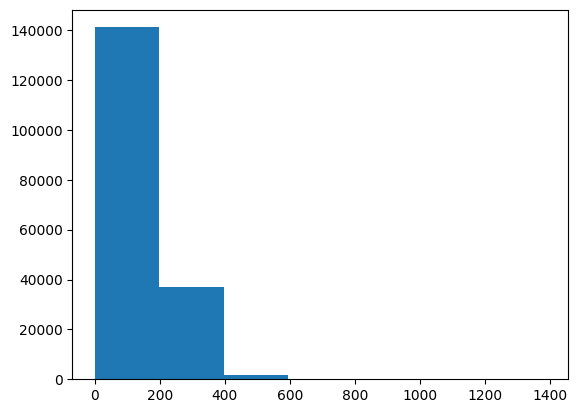

In [60]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens , bins = 7);

In [61]:
# Find what character length covers 95% of sequences
output_seq_char_length = int(np.percentile(char_lens , 95))
output_seq_char_length


290

In [62]:
# Get all keyboard characters. Text vectorizerdeki max tokensi bulmaya çalışıyoruz. Fakat burda farklı bir yaklaşım yapacağız. Çünkü mesela d harfi çok fazla kez kullanılıyor kelimelerde fakat d her zaman aynı d. Bu yüzden bunu bir kere kullanmamız gerekiyor.
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet
# We will use len of this alphabet object



'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2  # Add 2 for space and OOV token (OOV = out of vocab , '[UNK]' )
char_vectorizer = TextVectorization(
    max_tokens = NUM_CHAR_TOKENS ,
    output_sequence_length = output_seq_char_length ,
    name = "char_vectorizer"
)

In [64]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [65]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in our character vocab : \n {len(char_vocab)}")
print(f"\n5 most common character in our vocab :\n {char_vocab[ : 5]}")
print(f"\n5 least common character in our vocab : \n {char_vocab[ -5 : ]}")

Number of different characters in our character vocab : 
 28

5 most common character in our vocab :
 ['', '[UNK]', 'e', 't', 'i']

5 least common character in our vocab : 
 ['k', 'x', 'z', 'q', 'j']


In [66]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text : \n {random_train_chars}")
print(f"\nLength of random train chars : \n {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\n Vectorized chars : \n {vectorized_chars}")
print(f"\n Length of vectorized chars : \n {len(vectorized_chars[0])}")

Charified text : 
 t h e   m e d i a n   a g e   w a s   @   y e a r s   ,   t h e   m e d i a n   k p s   w a s   @   ,   a n d   t h e   p r e d o m i n a n t   h i s t o l o g i e s   w e r e   n o n - s m a l l   c e l l   l u n g   c a n c e r   (   @   p a t i e n t s   )   a n d   m e l a n o m a   (   @   )   .

Length of random train chars : 
 120

 Vectorized chars : 
 [[ 3 13  2 15  2 10  4  5  6  5 18  2 20  5  9 19  2  5  8  9  3 13  2 15
   2 10  4  5  6 23 14  9 20  5  9  5  6 10  3 13  2 14  8  2 10  7 15  4
   6  5  6  3 13  4  9  3  7 12  7 18  4  2  9 20  2  8  2  6  7  6  9 15
   5 12 12 11  2 12 12 12 16  6 18 11  5  6 11  2  8 14  5  3  4  2  6  3
   9  5  6 10 15  2 12  5  6  7 15  5  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0 

# Create a character level embedding layer

In [67]:
# Create char embedding layer

char_embed = layers.Embedding(
    input_dim = len(char_vocab) ,
    output_dim = 25 , # In paper , they say we should use 25 for output dim ,
    mask_zero = True ,
    name = "char_embed"
)

In [68]:
# Test our character level embedding layer
print(f"Random sentence : \n {random_train_chars}")
print(f"\nLength of our sentence : \n {len(random_train_chars)}")
embedded_sentence = char_embed(char_vectorizer([random_train_chars]))
print(f"\nEmbedded form of our sentence : \n {embedded_sentence}")
print(f"\n Length of embedded form's sentence : \n {len(embedded_sentence[0])}")
print(f"\n Shape of embedded form's sentence : \n {embedded_sentence.shape}")

Random sentence : 
 t h e   m e d i a n   a g e   w a s   @   y e a r s   ,   t h e   m e d i a n   k p s   w a s   @   ,   a n d   t h e   p r e d o m i n a n t   h i s t o l o g i e s   w e r e   n o n - s m a l l   c e l l   l u n g   c a n c e r   (   @   p a t i e n t s   )   a n d   m e l a n o m a   (   @   )   .

Length of our sentence : 
 301

Embedded form of our sentence : 
 [[[ 0.04052401 -0.03843371 -0.02699591 ...  0.03207489  0.02819092
   -0.02547239]
  [ 0.03394974  0.00813297 -0.03180631 ... -0.01521755  0.04015753
    0.00550324]
  [ 0.02259452  0.04996226  0.00782406 ...  0.04378096 -0.00027708
    0.013389  ]
  ...
  [-0.04584054  0.03226138  0.01263129 ...  0.03029636 -0.00045728
   -0.04672183]
  [-0.04584054  0.03226138  0.01263129 ...  0.03029636 -0.00045728
   -0.04672183]
  [-0.04584054  0.03226138  0.01263129 ...  0.03029636 -0.00045728
   -0.04672183]]]

 Length of embedded form's sentence : 
 290

 Shape of embedded form's sentence : 
 (1, 290, 25)


In [69]:
# Create Conv1D model with character-level embedding
from tensorflow.keras import layers

inputs = layers.Input(shape = ( 1 ,) , dtype = tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D( 64 , activation = "relu" , kernel_size = 5 , padding = "same")(x)
x = layers.GlobalMaxPool1D()(x)  # Global average poolingte kötü sonuç alırsan maxpool dene.
outputs = layers.Dense( 5 , activation = "softmax")(x)

model_3 = tf.keras.Model( inputs , outputs)




In [70]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [71]:
train_dataset_char = tf.data.Dataset.from_tensor_slices((train_chars , train_labels_encoded))
test_dataset_char = tf.data.Dataset.from_tensor_slices((test_chars , test_labels_encoded))
val_dataset_char = tf.data.Dataset.from_tensor_slices((val_chars , val_labels_encoded))

train_dataset_char = train_dataset_char.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_char = test_dataset_char.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_char = val_dataset_char.batch(32).prefetch(tf.data.AUTOTUNE)


In [72]:
# Compile a model
model_3.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )

# Fit the model

hist_3 = model_3.fit(
    train_dataset_char ,
    epochs = 3 ,
    validation_data = val_dataset_char

)

Epoch 1/3
5627/5627 [==============================] - 41s 7ms/step - loss: 0.8850 - accuracy: 0.6547 - val_loss: 0.7741 - val_accuracy: 0.7052
Epoch 2/3
5627/5627 [==============================] - 39s 7ms/step - loss: 0.7451 - accuracy: 0.7172 - val_loss: 0.7380 - val_accuracy: 0.7180
Epoch 3/3
5627/5627 [==============================] - 37s 7ms/step - loss: 0.7136 - accuracy: 0.7298 - val_loss: 0.7222 - val_accuracy: 0.7245


In [73]:
# Make predictions with our character-level model
model_3_pred_probs = model_3.predict(val_dataset_char)
model_3_pred_probs


945/945 [==============================] - 3s 3ms/step


array([[1.7027967e-01, 2.6103663e-01, 5.0603159e-02, 4.5197216e-01,
        6.6108406e-02],
       [1.6177443e-01, 6.5256774e-01, 4.6086186e-03, 1.7096780e-01,
        1.0081367e-02],
       [2.8668737e-01, 6.5064929e-02, 7.5158216e-02, 5.3349888e-01,
        3.9590586e-02],
       ...,
       [3.0950271e-03, 1.3394037e-02, 9.6275704e-03, 1.0819150e-03,
        9.7280145e-01],
       [4.8360132e-02, 2.4218391e-01, 3.0041766e-01, 1.0356071e-02,
        3.9868227e-01],
       [5.2524194e-02, 9.3952340e-01, 1.1770071e-03, 7.3060259e-04,
        6.0448768e-03]], dtype=float32)

In [74]:
# Convert prediction probabilities to classes
model_3_pred = tf.argmax(model_3_pred_probs , axis = 1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 4, 1])>

In [75]:
# Calculate the results

model_3_results = calculate_results(
    y_true = val_labels_encoded_labelencoder ,
    y_pred = model_3_pred
)
model_3_results

{'accuracy': 72.45465377995498,
 'precision': 0.7212349345654875,
 'recall': 0.7245465377995498,
 'f1': 0.7165747715773316}

# Model 4 : Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar 'model_1')
2. Create a character-level embedding model (similar 'model_3')
3. Combine step 1 and 2 with a concatenate ('layers.Concatenate')
4. Build a series of output layers on top of step 3 similar to figure 1 and section 4.2 in paper.
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [76]:
# 1. Setup token inputs/model. This is for step 1 : token-level embedding . We used pre-trained model from tensorflow hub.
token_inputs = layers.Input(shape = [] , dtype = tf.string)
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense( 128 , activation = "relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs , token_outputs)

# 2. Setup char inputs/model. This is step 2 : character level embedding and we will use bidirectional LSTM layer
char_inputs = layers.Input(shape = (1,) , dtype = tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)  # bi_lstm shown in figure 1 https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(char_inputs , char_bi_lstm)

# 3. Concatenate token and char outputs (hybrid token embedding)

token_char_concat = tf.keras.layers.Concatenate(name = "token_char_hybrid")([
    token_model.output ,  #.output ile modellerimizin outputunu çekiyoruz. Eğer papera bakarsak tokenla character embedding modellerinin outputlarını concatenate ediyoruz aslında burda bunu yaptık.
    char_model.output  # Order önemli. Yukardaki modelde ilk hangisini oluşturduysak burda da ilk onun outputunu çekiyoruz.
])

# 4. Create output layers - adding in DropOut , discussed in section 4.2
combined_dropout = layers.Dropout(0.5)(token_char_concat)  # Dropout layer eklemek overfittingi önlüyor. 0.5 dediğimiz %50 demek oluyor. Overfitting train datayı çok iyi öğrenmek olduğu için dropout layer modelin içindeki %50 lik kısmın weightslerini sıfırlıyor ve overfittingi önlüyor.
# token_char_concat ile de dropout layerımızı matchliyoruz.
combined_dense = layers.Dense( 128 , activation = "relu")(combined_dropout) # Paperda bi lstm layer var concatenate işleminden sonra biz onun yerine burda dense layer kullandık.
final_dropout = layers.Dropout(0.5)(combined_dense)  # Paperda prediction layerdan önce de dropout yapıyor prediction layer dediğimiz şey aslında output layer.
outputs_layer = layers.Dense( 5 , activation = "softmax")(final_dropout)

# 5. Constract model with char and token inputs

model_4= tf.keras.Model( [ token_model.input , char_model.input ] , outputs_layer )



In [77]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_5[0][0]']                
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['input_4[0][0]']          

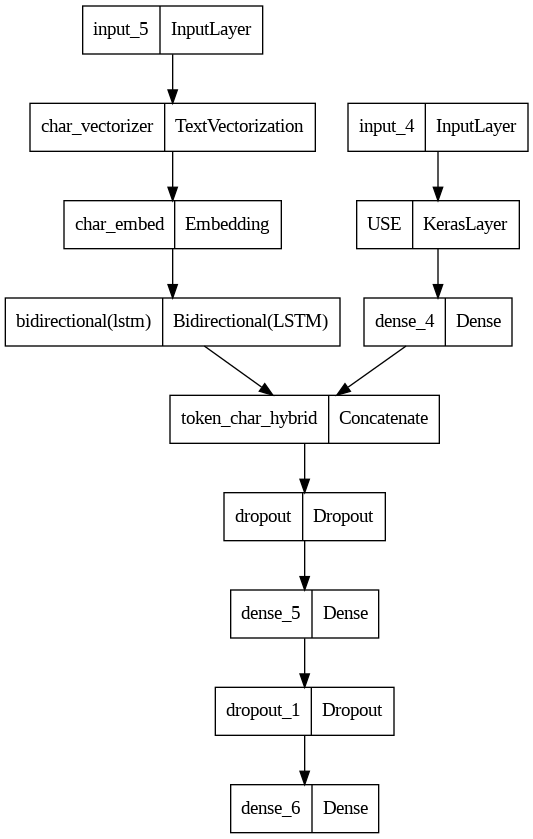

In [78]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4)

In [79]:
# Compile a model
model_4.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )


# Combining token and character data into tf.data Dataset

In [80]:
# Create dataset for our model
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data. Order önemli yani yukarıda modelimizi oluştururkenki model_4= tf.keras.Model( [ token_model.input , char_model.input ] , outputs_layer ) bu koddaki order neyse ona göre yazıcaz bunları da.
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars)) # make data
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_encoded) # make labels
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)) # combine data and labels


train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [81]:
# Fit the model
hist_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 52s 71ms/step - loss: 0.9795 - accuracy: 0.6077 - val_loss: 0.7831 - val_accuracy: 0.7011
Epoch 2/3
562/562 [==============================] - 39s 70ms/step - loss: 0.8025 - accuracy: 0.6898 - val_loss: 0.7232 - val_accuracy: 0.7251
Epoch 3/3
562/562 [==============================] - 28s 50ms/step - loss: 0.7759 - accuracy: 0.7019 - val_loss: 0.6965 - val_accuracy: 0.7311


In [82]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 24s 25ms/step - loss: 0.7039 - accuracy: 0.7310


[0.7039335370063782, 0.7309678196907043]

In [83]:
# Make predictions
model_4_pred_probs = model_4.predict(val_char_token_dataset) # Prediction yaparken prefetch datamızı oluşturduğumuz y_true ları kullanmamız gerek çünkü ikisi aynı formatta ve biz aynı formatta olan şeylerle predict edebiliyoruz.
model_4_pred_probs  # Softmax activation sayesinde probabilities alıyoruz bunun outputunda.

945/945 [==============================] - 25s 23ms/step


array([[4.7887000e-01, 2.8538701e-01, 4.3383976e-03, 2.2191052e-01,
        9.4941286e-03],
       [3.6619395e-01, 4.1724250e-01, 5.6328145e-03, 2.0766328e-01,
        3.2673960e-03],
       [2.6591858e-01, 7.2470665e-02, 4.0320463e-02, 5.9683853e-01,
        2.4451738e-02],
       ...,
       [4.7009980e-04, 5.3200372e-03, 5.5634785e-02, 1.7410173e-04,
        9.3840092e-01],
       [8.3027454e-03, 6.5723307e-02, 2.0714685e-01, 2.8241775e-03,
        7.1600294e-01],
       [3.1490007e-01, 3.4005386e-01, 2.6258948e-01, 2.9492367e-02,
        5.2964233e-02]], dtype=float32)

In [84]:
model_4_pred = tf.argmax(model_4_pred_probs , axis = 1)
model_4_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [85]:
model_4_results = calculate_results(
    y_true = val_labels_encoded_labelencoder ,
    y_pred = model_4_pred
)
model_4_results

{'accuracy': 73.09678273533694,
 'precision': 0.7310866722766347,
 'recall': 0.7309678273533695,
 'f1': 0.7295074632895181}

# Model 5 : Transfer learning with pre-trained token embeddings + character embeddings + positional embeddings

**Note:** Any engineered features used to train a model need to be available at test time. In our case , line numbers and total lines are available. Yani test datanda da train ettiğin dataya uyguladıgın seyleri uygulayabilmen ve uygulaman lazım.

In [86]:
# How many different line numbers are there?
train_df["line_number"].value_counts()
len(train_df["line_number"])

180040

<Axes: ylabel='Frequency'>

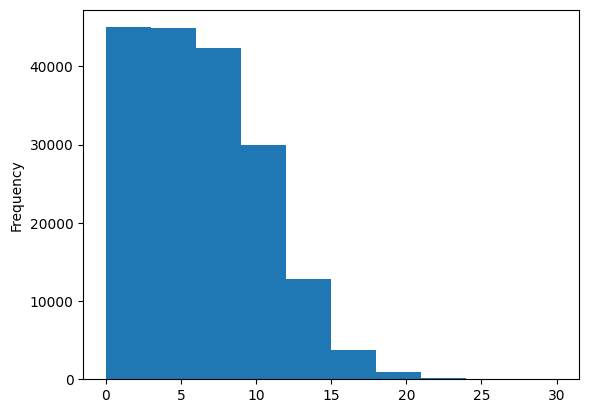

In [87]:
# Check the distrubiton of line_number column
train_df.line_number.plot.hist()

### One hot encoding uygulayacagımız zaman vectorün cok uzun olmamasını istiyoruz. Şu an burda 30 long bir vector çok uzun oluyor ve aslına bakarsak zaten 15. line dan sonra zaten çok küçük sayılar var yani datamızda çok küçük bir yer kaplıyor bu yüzden 15 ten sonrasını ignorelayacağız.

In [88]:
# Use TensorFlow to create one-hot-encoded tensors of our line_number column
from tensorflow import one_hot
train_lines_number_one_hot = one_hot(
    train_df[ "line_number"].to_numpy() ,  # Tensorflow one hot input olarak array alıyor içine.
    depth = 15 ,  #Depth ile one hot encoder vectorumuzun uzunlugunu belirliyoruz.
)
# One hot encoder kullanmamızın sebebi eğer kullanmazsak modelimiz line number = 2 geldiğinde line number = 1 in 2 katı sanacak.
val_lines_number_one_hot = one_hot(
    val_df["line_number"].to_numpy() ,
    depth = 15
)
test_lines_number_one_hot = one_hot(
    test_df["line_number"].to_numpy() ,
    depth = 15
)

train_lines_number_one_hot[ : 14] , train_lines_number_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

### We will do the same process to our total line numbers.

In [89]:
# How many total lines sample are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

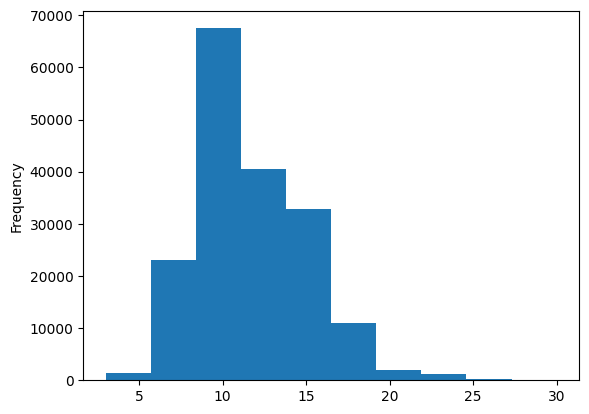

In [90]:
# Check the distribution of total_lines
train_df.total_lines.plot.hist()

In [91]:
# Check the coverage of 95% of total_lines
np.percentile(train_df.total_lines , 95)  # 20 de %98 ini coverlıyor. Coverage kısmını 98 yaparsak görebiliriz

18.0

In [92]:
train_total_lines_one_hot = one_hot(
    train_df[ "total_lines"].to_numpy() ,  # Tensorflow one hot input olarak array alıyor içine.
    depth = 20 ,  #Depth ile one hot encoder vectorumuzun uzunlugunu belirliyoruz.
)
# One hot encoder kullanmamızın sebebi eğer kullanmazsak modelimiz line number = 2 geldiğinde line number = 1 in 2 katı sanacak.
val_total_lines_one_hot = one_hot(
    val_df["total_lines"].to_numpy() ,
    depth = 20
)
test_total_lines_one_hot = one_hot(
    test_df["total_lines"].to_numpy() ,
    depth = 20
)

train_total_lines_one_hot[ : 10] , train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

# Create a tribrid embedding model

1. Create a token-level embedding model.
2. Create a char-level embedding model.
3. Create a model for line_number feature.
4. Create a model for total_lines feature.
5. Combine the outputs of step 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilites.
8. Combine the inputs of 1 , 2 , 3 , 4 and outputs of into tf.keras.Model

In [94]:
train_lines_number_one_hot[0].shape

TensorShape([15])

In [ ]:
train_total_lines_one_hot.shape

In [96]:
# Step 1 : Creating token-level embedding model

token_inputs_tri = layers.Input( shape = [] , dtype = tf.string)
token_embedding_tri = sentence_encoder_layer(token_inputs_tri)
token_outputs_tri = layers.Dense( 128 , activation = "relu")(token_embedding_tri)
token_model_tri = tf.keras.Model(token_inputs_tri , token_outputs_tri )

# Step 2 : Creating char-level embedding model with bi-LSTM
char_inputs_tri = layers.Input(shape = ( 1 , ) , dtype = tf.string)
char_vectorizer_tri = char_vectorizer(char_inputs_tri)
char_embedding_tri = char_embed(char_vectorizer_tri)
char_bi_lstm_tri = layers.Bidirectional(layers.LSTM(24))(char_embedding_tri)
char_model_tri = tf.keras.Model(char_inputs_tri , char_bi_lstm_tri )

# Step 3 : Create a model for line_number feature
line_number_tri = layers.Input( shape = (15 , ) , dtype = tf.float32)  # Shape in 15 olmasının sebebi one hot encoded ettigimiz 1 sample ın shape i 15.
x = layers.Dense( 32 , activation = "relu")(line_number_tri)
line_number_model = tf.keras.Model(line_number_tri , x)

# Step 4 : Create a model for total_lines feature.
total_lines_tri = layers.Input( shape = ( 20 ,) , dtype = tf.float32)  # Burda da yukarda olan aynı sebepten dolayı 20 yapıyoruz shape i cünkü one hot encode ederken 20 uzunlukta vektör oluşturduk.
y = layers.Dense( 32 , activation = "relu")(total_lines_tri)
total_lines_model = tf.keras.Model(total_lines_tri , y)

# Step 5 : Combine the outputs of step 1 and 2 using tf.keras.layers.Concatenate
combined_embeddings = tf.keras.layers.Concatenate( name = "token_char_concat")(
    [
    token_model_tri.output ,
    char_model_tri.output
    ]
    )
z = layers.Dense( 256 , activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)  # Written at paper.

# Step 6 : Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate

tribrid_embeddings = tf.keras.layers.Concatenate(name = "concat_every_layer")(
    [
       line_number_model.output ,
       total_lines_model.output ,
       z
    ]
)

# Step 7 : Create an output layer.
output_layer = layers.Dense( 5 , activation = "softmax")(tribrid_embeddings)

# Step 8 : Put together model with all kinds of inputs and output

model_5 = tf.keras.Model(
    [  token_model_tri.input ,  char_model_tri.input , line_number_model.input , total_lines_model.input  ] , output_layer
)

1. The line numbers model does not need an embedding layer because it does not deal with sequential or categorical data. It only takes in the line numbers, which are already in numerical format, as input. Therefore, there is no need for the model to learn a new representation of the input data through an embedding layer.

2. The shape of 32 hidden units in the line number model's output layer is determined through experimentation and hyperparameter tuning. The authors likely tried different numbers of hidden units and found that 32 provided the best balance between model complexity and performance.

3. A dense layer can be used as an embedding layer if the input data is numerical and does not require a learned representation. However, if the input data is categorical or sequential, it is recommended to use an embedding layer as it can learn a more effective representation of the input data. Additionally, embedding layers can help reduce the dimensionality of the input data, which can improve model performance and efficiency.

In [97]:
model_5.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_9[0][0]']                
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['input_8[0][0]']         

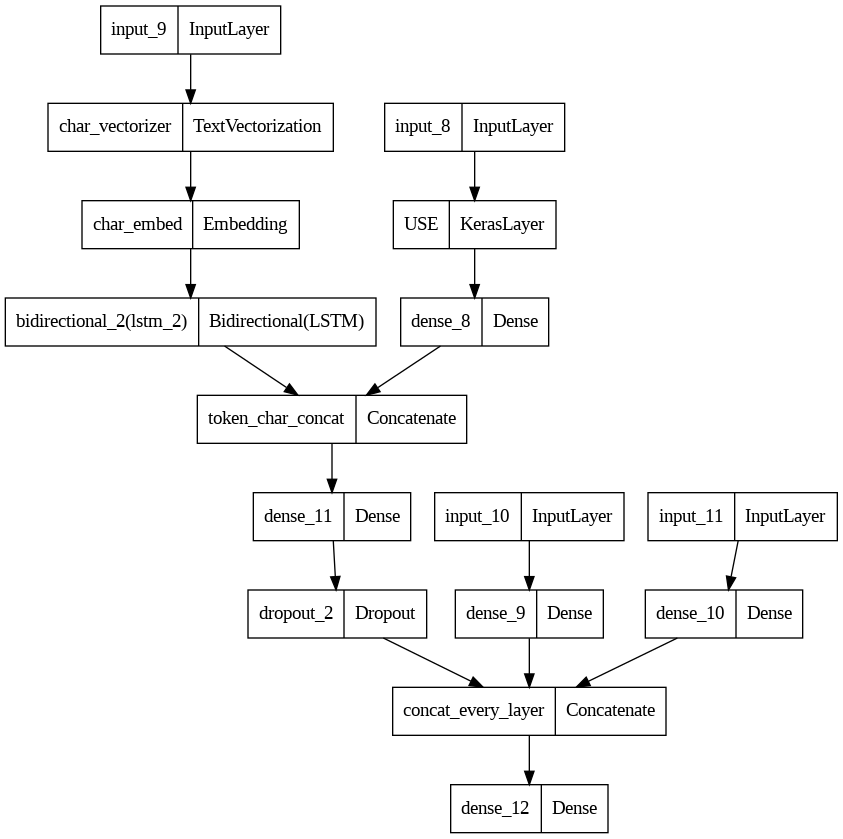

In [98]:
# Plot model_5 to explore it visually.
from keras.utils import plot_model
plot_model(model_5)

What is label smoothing?

For example , if our model gets too confident on a single class ( e.g. its prediction probability is really high) , it may get stuck on that class and not consider other classes.


Really confident (these are prediction probabilities): [ 0.0 , 0.0 , 1.0 , 0.0 , 0.0]  (Burda aslında model 3. classı 1 olasılıkla yani kesinlikle bulduğu için o classa stuck kalıyor ben %100 le zaten buldum bu artık tamam diyor biz bunu önlemek istiyoruz)


What label smoothing does is it assigns some of the value from the highest pred prob to other classes , in turn , hopefully improving generalization :


[ 0.01 , 0.01 , 0.96 , 0.01 , 0.01]  


aslında label smoothing bu hale getiriyor ve dont get stuck third class , dont get tunnel vision on one class diyor. label_smoothing = 0.2 dediğimizde pred probu 1 çıkan classtan 0.01 alıp diğer classlara dağıtıyor

https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [99]:
# Compile token , char and positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2) , # label_smoothing helps to prevent overfitting.
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )

# Create tribrid embedding dataset using tf.data

In [104]:
train_char_token_positional_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars , train_lines_number_one_hot , train_total_lines_one_hot)) # make data. Order önemli yani yukarıda modelimizi oluştururkenki model_4= tf.keras.Model( [ token_model.input , char_model.input ] , outputs_layer ) bu koddaki order neyse ona göre yazıcaz bunları da.
train_char_token_positional_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded) # make labels
train_char_token_positional_dataset = tf.data.Dataset.zip((train_char_token_positional_data, train_char_token_labels))

val_char_token_positional_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars , val_lines_number_one_hot , val_total_lines_one_hot)) # make data. Order önemli yani yukarıda modelimizi oluştururkenki model_4= tf.keras.Model( [ token_model.input , char_model.input ] , outputs_layer ) bu koddaki order neyse ona göre yazıcaz bunları da.
val_char_token_positional_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded) # make labels
val_char_token_positional_dataset = tf.data.Dataset.zip((val_char_token_positional_data, val_char_token_positional_labels))

test_char_token_positional_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars , test_lines_number_one_hot , test_total_lines_one_hot)) # make data. Order önemli yani yukarıda modelimizi oluştururkenki model_4= tf.keras.Model( [ token_model.input , char_model.input ] , outputs_layer ) bu koddaki order neyse ona göre yazıcaz bunları da.
test_char_token_positional_labels = tf.data.Dataset.from_tensor_slices(test_labels_encoded) # make labels
test_char_token_positional_dataset = tf.data.Dataset.zip((test_char_token_positional_data, test_char_token_positional_labels))

train_char_token_positional_dataset = train_char_token_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_positional_dataset = test_char_token_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_positional_dataset = val_char_token_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [107]:
# Check the input shape
train_char_token_positional_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [105]:
# Fit the model

hist_5 = model_5.fit(train_char_token_positional_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_positional_dataset)),
                              epochs=3,
                              validation_data=val_char_token_positional_dataset,
                              validation_steps=int(0.1 * len(val_char_token_positional_dataset)))

Epoch 1/3
562/562 [==============================] - 48s 62ms/step - loss: 1.0942 - accuracy: 0.7259 - val_loss: 0.9797 - val_accuracy: 0.8075
Epoch 2/3
562/562 [==============================] - 35s 63ms/step - loss: 0.9653 - accuracy: 0.8164 - val_loss: 0.9479 - val_accuracy: 0.8298
Epoch 3/3
562/562 [==============================] - 30s 53ms/step - loss: 0.9483 - accuracy: 0.8243 - val_loss: 0.9370 - val_accuracy: 0.8354


In [108]:
# Evaluate model_5
model_5.evaluate(val_char_token_positional_dataset)

945/945 [==============================] - 26s 27ms/step - loss: 0.9356 - accuracy: 0.8337


[0.9355833530426025, 0.8337084650993347]

In [109]:
# Pred probs of our model
model_5_pred_probs = model_5.predict(val_char_token_positional_dataset)
model_5_pred_probs


945/945 [==============================] - 29s 25ms/step


array([[0.5061157 , 0.12426122, 0.0085987 , 0.34212008, 0.01890434],
       [0.5178061 , 0.10561638, 0.05099487, 0.31331155, 0.01227107],
       [0.29688162, 0.11072197, 0.15494236, 0.35634926, 0.08110472],
       ...,
       [0.03830217, 0.10990208, 0.04777738, 0.03713042, 0.7668879 ],
       [0.02794752, 0.317924  , 0.08588815, 0.02559988, 0.54264045],
       [0.15275498, 0.6545181 , 0.08134989, 0.04024154, 0.07113548]],
      dtype=float32)

In [110]:
# Predictions of our model
model_5_preds = tf.argmax(model_5_pred_probs , axis = 1)
model_5_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [111]:
# Calculate our model result
model_5_results = calculate_results(
    y_true = val_labels_encoded_labelencoder ,
    y_pred = model_5_preds
)
model_5_results

{'accuracy': 83.37084602144843,
 'precision': 0.8325711163903804,
 'recall': 0.8337084602144843,
 'f1': 0.8327807374554193}

In [114]:
 # Compare all of our models results
all_model_results = pd.DataFrame(
    {
        "model_0_baseline_results": baseline_results ,
        "model_1_custom_token_embedding": model_1_results ,
        "model_2_pretrained_token_embedding": model_2_results ,
        "model_3_custom_char_embedding": model_3_results ,
        "model_4_char_and_token_embedding": model_4_results ,
        "model_5_char_token_positional_embedding": model_5_results
    }
)
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline_results,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,79.246657,0.789130,0.792467,0.789556
model_2_pretrained_token_embedding,76.866808,0.765981,0.768668,0.764442
model_3_custom_char_embedding,72.454654,0.721235,0.724547,0.716575
model_4_char_and_token_embedding,73.096783,0.731087,0.730968,0.729507
model_5_char_token_positional_embedding,83.370846,0.832571,0.833708,0.832781


In [115]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100


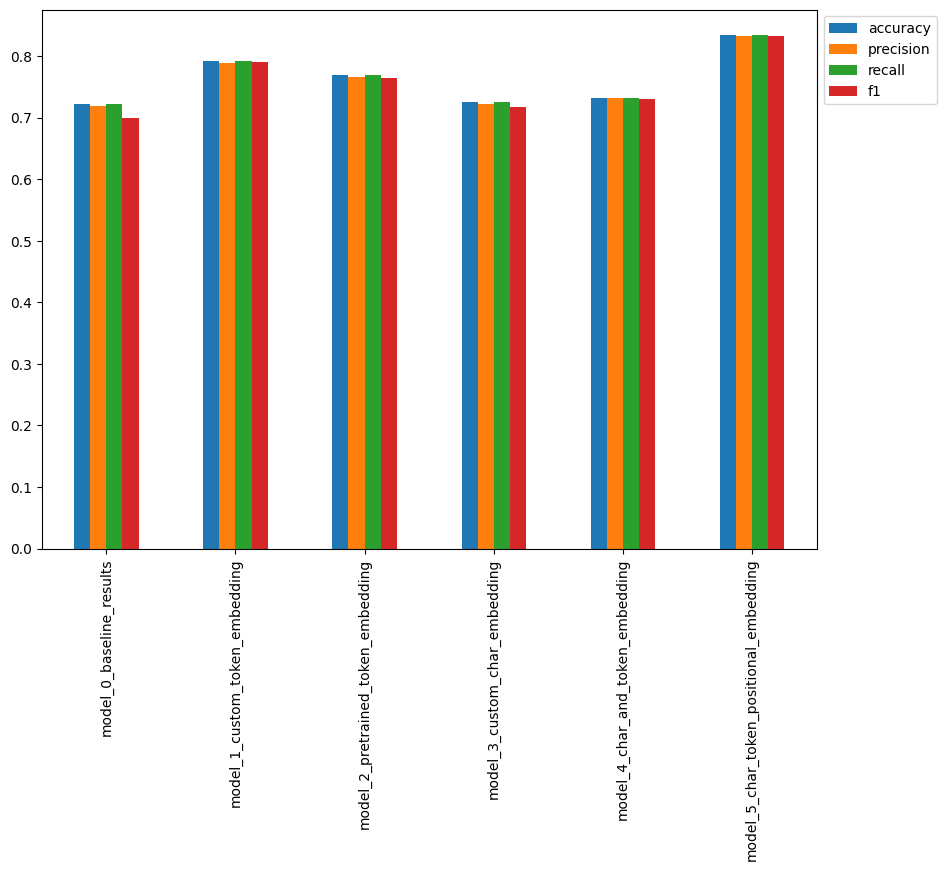

In [118]:
# Plot all of results and compare it
all_model_results.plot(kind = "bar" , figsize = ( 10 , 7 )).legend(bbox_to_anchor = (1.0 , 1.0))

<Axes: >

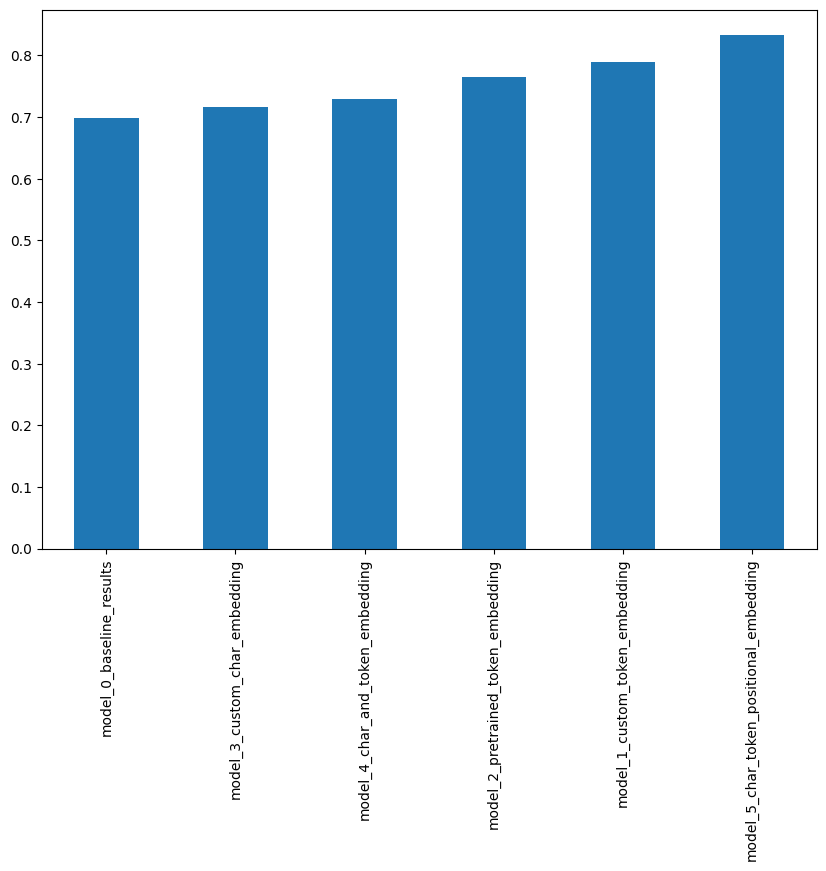

In [120]:
# Sort models results by f1 scores
all_model_results.sort_values("f1" , ascending = True)["f1"].plot(kind = "bar" , figsize = ( 10 , 7 ))

# Save and load model

In [121]:
# Save  model_5 to SavedModel format (default)

model_5.save("model_5_SavedModel_format")

In [122]:
# Load in the SavedModel format

loaded_model_5_SavedModel_format = tf.keras.models.load_model("model_5_SavedModel_format")